<a href="https://colab.research.google.com/github/MarioAuditore/TDA-for-Travelling-Salesman/blob/main/train_tsp_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TDA-for-Travelling-Salesman

Transformer based on the work of Xavier Bresson, Thomas Laurent, Feb 2021<br>

Arxiv : https://arxiv.org/pdf/2103.03012.pdf<br>
Talk : https://ipam.wistia.com/medias/0jrweluovs<br>
Slides : https://t.co/ySxGiKtQL5<br>

This code trains the transformer network by reinforcement learning.<br>
Use the beam search code to test the trained network.


In [1]:
# !git clone https://github.com/MarioAuditore/TDA-for-Travelling-Salesman.git

# import os
# os.chdir('/content/TDA-for-Travelling-Salesman')

In [2]:
# !pip install 'pyconcorde @ git+https://github.com/jvkersch/pyconcorde'
# !pip install giotto-ph

In [3]:
# ================
# Libs
# ================

import torch
import torch.nn as nn
from tqdm import tqdm
import gph

# Models
from tsp_transformer.model import TSP_net, compute_tour_length


import time
import argparse
import os
from datetime import datetime


# visualization
%matplotlib inline
# from IPython.display import set_matplotlib_formats, clear_output
# set_matplotlib_formats('png2x','pdf')
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd


import networkx as nx
from scipy.spatial.distance import pdist, squareform
from concorde.tsp import TSPSolver # !pip install -e pyconcorde

from joblib import Parallel, delayed

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(42)
torch.manual_seed(42)

pass

In [4]:
###################
# Hardware : CPU / GPU(s)
###################

if torch.backends.mps.is_available():
    gpu_id = '0'
    device = torch.device("mps")

elif torch.cuda.is_available():
    gpu_id = '1' # select a single GPU
    # gpu_id = '2,3' # select multiple GPUs
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    device = torch.device("cuda")
    print('GPU name: {:s}, gpu_id: {:s}'.format(torch.cuda.get_device_name(0),gpu_id))

else:
    device = torch.device("cpu")
    gpu_id = -1 # select CPU


print(device)

GPU name: Tesla V100-SXM2-16GB, gpu_id: 1
cuda


In [5]:
# ================
# Hyper-parameters
# ================

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

args = DotDict()
args.gpu_id = gpu_id

# TSP problem number of nodes
# args.nb_nodes = 10 # TSP10
# args.nb_nodes = 20 # TSP20
args.nb_nodes = 50 # TSP50

# Transformer parameters
args.dim_emb = 128 # dimension of embeddings in transformer
args.dim_ff = 512 # dimension of feed forward layers
args.dim_nodes = 2
args.dim_model_input = 8 # dimension of input features
args.nb_layers_encoder = 6
args.nb_layers_decoder = 2
args.nb_heads = 8

#
args.nb_epochs = 200 # number of epochs
args.batch_size = 1500 # batch size
args.nb_batch_per_epoch = 250 # number of batches to generate on each epoch for training
args.nb_batch_eval = 100 # number of batches to generate on each epoch for evaluation
args.lr = 1e-3 # optimiser lr
args.tol = 1e-3 # model should perform better w.r.t tolerance to be updated
args.batchnorm = True  # if batchnorm=True  than batch norm is used
# args.batchnorm = False # if batchnorm=False than layer norm is used
args.max_len_PE = 1000

print(args)

{'gpu_id': '1', 'nb_nodes': 50, 'dim_emb': 128, 'dim_ff': 512, 'dim_nodes': 2, 'dim_model_input': 8, 'nb_layers_encoder': 6, 'nb_layers_decoder': 2, 'nb_heads': 8, 'nb_epochs': 500, 'batch_size': 1500, 'nb_batch_per_epoch': 250, 'nb_batch_eval': 100, 'lr': 0.0003, 'tol': 0.001, 'batchnorm': True, 'max_len_PE': 1000}


# Training
## Setup

In [6]:
###################
# Instantiate a training network and a baseline network
###################

try:
    del model_train # remove existing model
    del model_baseline # remove existing model
except:
    pass

model_train = TSP_net(args.dim_model_input,
                      args.dim_emb,
                      args.dim_ff,
                      args.nb_layers_encoder,
                      args.nb_layers_decoder,
                      args.nb_heads,
                      args.max_len_PE,
                      batchnorm=args.batchnorm)

model_baseline = TSP_net(args.dim_model_input,
                         args.dim_emb,
                         args.dim_ff,
                         args.nb_layers_encoder,
                         args.nb_layers_decoder,
                         args.nb_heads,
                         args.max_len_PE,
                         batchnorm=args.batchnorm)

if torch.cuda.device_count() > 1:
    print(torch.cuda.device_count() + " cuda devices found, doing parallel training.")
    model_train = nn.DataParallel(model_train)
    model_baseline = nn.DataParallel(model_baseline)

optimizer = torch.optim.AdamW(model_train.parameters(), lr = args.lr)

model_train = model_train.to(device)
model_baseline = model_baseline.to(device)
model_baseline.eval()

print(args); print('')


date_time_format = "%Y.%m.%d-%H:%M:%S"
date_time_str = datetime.now().strftime(date_time_format)

# Logs
if not  os.path.exists("logs"):
    os.system("mkdir logs")
# time_stamp=datetime.now().strftime("%y-%m-%d--%H-%M-%S")
file_name = 'logs'+'/'+date_time_str + "-n{}".format(args.nb_nodes) + "-gpu{}".format(args.gpu_id) + ".txt"
file = open(file_name,"w",1)
file.write(date_time_str+'\n\n')
for arg in vars(args):
    file.write(arg)
    hyper_param_val="={}".format(getattr(args, arg))
    file.write(hyper_param_val)
    file.write('\n')
file.write('\n\n')
plot_performance_train = []
plot_performance_baseline = []
all_strings = []
epoch_ckpt = 0
tot_time_ckpt = 0


# # Uncomment these lines to re-start training with saved checkpoint
# ====================================================================
# checkpoint_file = "checkpoint/checkpoint_21-03-01--17-25-00-n50-gpu0.pkl"
# checkpoint = torch.load(checkpoint_file, map_location=device)
# epoch_ckpt = checkpoint['epoch'] + 1
# tot_time_ckpt = checkpoint['tot_time']
# plot_performance_train = checkpoint['plot_performance_train']
# plot_performance_baseline = checkpoint['plot_performance_baseline']
# model_baseline.load_state_dict(checkpoint['model_baseline'])
# model_train.load_state_dict(checkpoint['model_train'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# print('Re-start training with saved checkpoint file={:s}\n  Checkpoint at epoch= {:d} and time={:.3f}min\n'.format(checkpoint_file,epoch_ckpt-1,tot_time_ckpt/60))
# del checkpoint
# ====================================================================



{'gpu_id': '1', 'nb_nodes': 50, 'dim_emb': 128, 'dim_ff': 512, 'dim_nodes': 2, 'dim_model_input': 8, 'nb_layers_encoder': 6, 'nb_layers_decoder': 2, 'nb_heads': 8, 'nb_epochs': 500, 'batch_size': 1500, 'nb_batch_per_epoch': 250, 'nb_batch_eval': 100, 'lr': 0.0003, 'tol': 0.001, 'batchnorm': True, 'max_len_PE': 1000}



## Topological features

In [7]:
def calculate_homology(points, max_columns=args.dim_model_input):

    output = gph.ripser_parallel(points.cpu().numpy() if isinstance(points, torch.Tensor) else points, return_generators=True)

    # extract data
    gens_1 = output['gens'][1]  # 1-homology bars
    dgms_1 = output['dgms'][1]  # their critical edges

    num_points = points.shape[0]
    features = np.asarray(points.cpu().numpy() if isinstance(points, torch.Tensor) else points)

    # pair generators with their barcodes
    paired_gens_barcodes = [(gen, dgms_1[i][1] - dgms_1[i][0]) for i, gen in enumerate(gens_1[0])]

    # sort by barcode length in decreasing order
    sorted_gens_barcodes = sorted(paired_gens_barcodes, key=lambda x: x[1], reverse=True)

    # add the given number of features
    max_generators = (max_columns - features.shape[1]) // 2
    for gen, barcode in sorted_gens_barcodes[:max_generators]:
        H1_birth, H1_death = np.zeros(num_points), np.zeros(num_points)
        birth_vertices, death_vertices = gen[:2], gen[2:]
        H1_birth[birth_vertices] = barcode
        H1_death[death_vertices] = barcode

        features = np.hstack([features, H1_birth[:, None], H1_death[:, None]])

    # pad zeros
    current_columns = features.shape[1]
    if current_columns < max_columns:
        zero_columns_needed = max_columns - current_columns
        features = np.hstack([features, np.zeros((num_points, zero_columns_needed))])

    return features

## Train set

In [8]:
def generate_dataset(total_samples, batch_size, nb_nodes, dim_nodes, max_columns):
    # Pre-allocate memory for efficiency
    dataset = np.zeros((total_samples, nb_nodes, max_columns), dtype=np.float32)
    
    # Wrap the range function with tqdm for a progress bar
    for i in tqdm(range(0, total_samples, batch_size), desc='Generating dataset'):
        x = torch.rand(batch_size, nb_nodes, dim_nodes)
        features = np.array(Parallel(n_jobs=-1)(
            delayed(calculate_homology)(i, max_columns=max_columns) for i in x
        ), dtype=np.float32)
        
        end = min(i + batch_size, total_samples)  # Ensure we don't exceed total_samples
        dataset[i:end] = features[:end-i]
    
    return dataset

In [9]:
total_samples = 45 * 10**3
data_directory = 'train_eval_data'
filename = f'dataset_{total_samples // 10**3}K_samples_{args.nb_nodes}_nodes_{args.dim_model_input}_features.pkl'
path = os.path.join(data_directory, filename)

def generate_and_save(path):
    dataset = generate_dataset(total_samples, total_samples//1000, args.nb_nodes, args.dim_nodes, args.dim_model_input)
    os.makedirs(data_directory, exist_ok=True)  
    torch.save(dataset, path) 
    print(f'Dataset generated and saved to {path}')
    return dataset

dataset = torch.load(path) if os.path.exists(path) else generate_and_save(path)

max_columns = args.dim_model_input
dataset = dataset[:, :, :max_columns]  

from sklearn.model_selection import train_test_split
train_data, eval_data = train_test_split(dataset, test_size=0.25, random_state=42)

Generating dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:10<00:00, 14.16it/s]


Dataset generated and saved to train_eval_data/dataset_12K_samples_50_nodes_8_features.pkl


## Test set

In [14]:
def best_path(points):
    solution = TSPSolver.from_data(points[:, 0], points[:, 1], norm='GEO').solve(verbose=False)
    return compute_tour_length(points[None, :], solution.tour[None, :]).to('cpu')

def generate_and_save_test_data(test_size, n_nodes, dim_nodes, max_columns, data_dir="test_data"):
    x = torch.rand(test_size, n_nodes, dim_nodes, device='cpu')
    features = np.array(Parallel(n_jobs=-1)(
            delayed(calculate_homology)(i, max_columns=max_columns) for i in x
        ), dtype=np.float32)
    
    lengths = Parallel(n_jobs=-1)(delayed(best_path)(points[:, :2]) for points in x)
    best_length_mean = torch.tensor(lengths).mean()
    
    os.makedirs(data_dir, exist_ok=True)
    torch.save({'features': features, 'mean': best_length_mean}, f"{data_dir}/{test_size}tsp{n_nodes}_with_features.pkl")
    return features, best_length_mean

def load_or_generate_test_data(test_size, n_nodes, dim_nodes, max_columns):
    data_dir = "test_data"
    try:
        checkpoint = torch.load(f"{data_dir}/{test_size}tsp{n_nodes}_with_features.pkl")
        print(f'Loaded checkpoint for {n_nodes} nodes | Mean length: {checkpoint["mean"]}')
        return checkpoint['features'], checkpoint['mean']
    except FileNotFoundError:
        print('Checkpoint not found. Generating new test data.')
        return generate_and_save_test_data(test_size, n_nodes, dim_nodes, max_columns)

test_size = 1000
n_nodes = args.nb_nodes
dim_nodes = args.dim_nodes
nb_features = args.dim_model_input

x_test, x_test_optimal_length = load_or_generate_test_data(test_size, n_nodes, dim_nodes, nb_features)

Loaded checkpoint for 50 nodes | Mean length: 5.700061798095703


## Training loop

In [11]:
def batch_sampler(data, batch_size, shuffle=True):
    """
    Generator function that yields batches from the dataset randomly.
    """
    data_size = len(data)
    indices = np.arange(data_size)
    if shuffle:
        np.random.shuffle(indices)
    
    for start_idx in range(0, data_size, batch_size):
        end_idx = min(start_idx + batch_size, data_size)
        batch_indices = indices[start_idx:end_idx]
        yield data[batch_indices]

In [17]:
torch.manual_seed(42)
start_training_time = time.time()

# lists for saving the data
loss_train = 0
loss_arr = []
length_train = []
length_baseline = []
length_test = []
gap_history = []

train_data = torch.tensor(train_data, dtype=torch.float32).to(device)
eval_data = torch.tensor(eval_data, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)

pbar = tqdm(range(args.nb_epochs))

for epoch in pbar:

    # Train model for one epoch
    start = time.time()
    model_train.train()

    for data in batch_sampler(train_data, args.batch_size):

        # compute tours for model
        tour_train, sumLogProbOfActions = model_train(data.to(device), deterministic=False) # size(tour_train)=(batch_size, nb_nodes), size(sumLogProbOfActions)=(batch_size)

        # compute tours for baseline
        with torch.no_grad():
            tour_baseline, _ = model_baseline(data.to(device), deterministic=True)

        # get the lengths of the tours
        x = data[:, :, :2].to(device)
        L_train = compute_tour_length(x, tour_train) # size(L_train)=(batch_size)
        L_baseline = compute_tour_length(x, tour_baseline) # size(L_baseline)=(batch_size)

        # backprop
        loss = torch.mean((L_train - L_baseline) * sumLogProbOfActions )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train += loss.detach().item()

    loss_train /= args.nb_batch_per_epoch
    loss_arr.append(loss_train)


    time_one_epoch = time.time()-start
    time_tot = time.time()-start_training_time + tot_time_ckpt

    # Evaluate train model and baseline
    model_train.eval()
    mean_tour_length_train = 0
    mean_tour_length_baseline = 0

    for data in batch_sampler(eval_data, args.batch_size, shuffle=True):

        # compute tour for model and baseline
        with torch.no_grad():
            tour_train, _ = model_train(data.to(device), deterministic=True)
            tour_baseline, _ = model_baseline(data.to(device), deterministic=True)

        # get the lengths of the tours
        x = data[:, :, :2].to(device)
        L_train = compute_tour_length(x, tour_train)
        L_baseline = compute_tour_length(x, tour_baseline)

        mean_tour_length_train += L_train.mean().item()
        mean_tour_length_baseline += L_baseline.mean().item()

    mean_tour_length_train =  mean_tour_length_train / args.nb_batch_eval
    mean_tour_length_baseline =  mean_tour_length_baseline / args.nb_batch_eval
    length_train.append(mean_tour_length_train) # save
    length_baseline.append(mean_tour_length_baseline) # save

    # Evaluate train model and baseline and update if train model is better
    update_baseline = mean_tour_length_train + args.tol < mean_tour_length_baseline
    if update_baseline:
        model_baseline.load_state_dict(model_train.state_dict())

    # For new baseline compute TSPs for small test set
    with torch.no_grad():
        tour_baseline, _ = model_baseline(x_test, deterministic=True)
    x_test_coords = x_test[:, :, :2]
    mean_tour_length_test = compute_tour_length(x_test_coords, tour_baseline.to('cpu')).mean().item()
    length_test.append(mean_tour_length_test) # save

    # Compute optimality gap
    gap_train = mean_tour_length_test / x_test_optimal_length - 1.0
    gap_history.append(gap_train) 
    
    # Update the tqdm progress bar 
    pbar.set_description('Epoch: {:d}, epoch time: {:.3f}min, gap_train(%): {:.3f}, update: {}'.format(epoch, time_one_epoch / 60, 100 * gap_train, update_baseline))

    # Saving checkpoint
    checkpoint_dir = "checkpoint"
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    model_checkpoint_filename = (
        f"checkpoint_{date_time_str}"
        f"{args.nb_nodes} nodes, "
        f"gpu_id = {args.gpu_id}"
    )
    torch.save({
        'epoch': epoch,
        'time': time_one_epoch,
        'tot_time': time_tot,
        'loss': loss.item(),
        'TSP_length': [torch.mean(L_train).item(), torch.mean(L_baseline).item(), mean_tour_length_test],
        'plot_performance_train': plot_performance_train,
        'plot_performance_baseline': plot_performance_baseline,
        'mean_tour_length_test': mean_tour_length_test,
        'model_baseline': model_baseline.state_dict(),
        'model_train': model_train.state_dict(),
        'optimizer': optimizer.state_dict(),
        }, os.path.join(checkpoint_dir, model_checkpoint_filename))
    
plot_data_filename = (
    f"{date_time_str}, "
    f"{args.nb_nodes} nodes, "
    f"{args.nb_epochs} epochs, "
    f"{args.dim_model_input} features - "
    f"plots.pkl"
)
torch.save({
    'loss_train': loss_arr,
    'path_length_for_baseline': length_baseline,
    'path_length_on_test': length_test,
    'path_length_for_train': length_train,
    'gap_history': gap_history
    }, os.path.join(checkpoint_dir, plot_data_filename))

Epoch: 499, epoch time: 0.075min, gap_train(%): 4.272, update: False: 100%|███████████████████████████████████████████████| 500/500 [44:43<00:00,  5.37s/it]


In [18]:
plot_data_filename = (
    f"{date_time_str}, "
    f"{args.nb_nodes} nodes, "
    f"{args.nb_epochs} epochs, "
    f"{args.dim_model_input} features - "
    f"plots_continuation.pkl"
)
torch.save({
    'loss_train': loss_arr,
    'path_length_for_baseline': length_baseline,
    'path_length_on_test': length_test,
    'path_length_for_train': length_train,
    'gap_history': gap_history
    }, os.path.join(checkpoint_dir, plot_data_filename))

### Plot losses

In [19]:
file_path = os.path.join(checkpoint_dir, plot_data_filename)
checkpoint = torch.load(file_path)

# loss_arr = checkpoint['loss_train']
# length_baseline = checkpoint['path_length_for_baseline']
# length_test = checkpoint['path_length_on_test']
# length_train = checkpoint['path_length_for_train']
gap_history = checkpoint['gap_history']

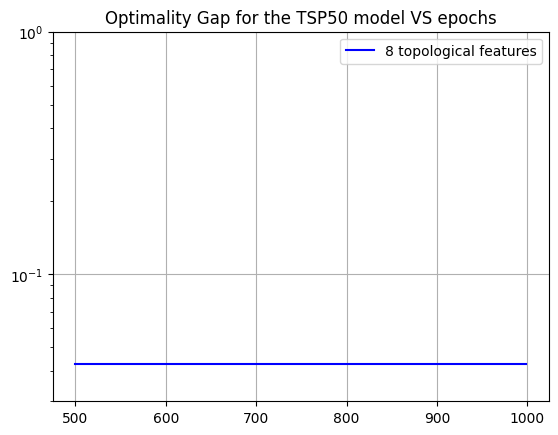

In [24]:
plt.plot(np.arange(500, 1000), [gap.numpy() for gap in gap_history], label=f'{args.dim_model_input} topological features', color='b')
plt.yscale('log')
plt.ylim([3e-2, 1])
plt.title('Optimality Gap for the TSP50 model VS epochs')
plt.grid(True)
plt.legend()
# plt.savefig('gap_10.jpg')
plt.show()

# Visualisation

#### Compute tours

In [25]:
concorde_tours = []
model_tours = []
lengths_with_concorde = []
lengths_with_nn = []

n_pairs = 2
n_rows = 3

for idx in range(n_pairs * n_rows): 
    points = np.array(x_test[idx].to('cpu'))
    model_tour = np.array(tour_baseline[idx].to('cpu'))

    concorde_tour = TSPSolver.from_data(points[:, 0], points[:, 1], norm='GEO').solve(verbose=False).tour
    concorde_tours.append(concorde_tour)
    
    length_with_concorde = compute_tour_length(torch.tensor(points[None, :]), torch.tensor(concorde_tour[None, :]))
    lengths_with_concorde.append(length_with_concorde.item())

    length_with_nn = compute_tour_length(x_test[idx][None, :], tour_baseline[idx][None, :].to('cpu'))
    lengths_with_nn.append(length_with_nn.item())

    model_tours.append(model_tour)

Problem Name: 93a837ec4b334f65935b8210e9a8945d
Problem Type: TSP
Number of Nodes: 50
Geographical Norm (CC_GEOGRAPHIC)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Setting kick type to close
Starting Cycle: 1280
   0 Steps   Best: 1091   0.00 seconds
  25 Total Steps.
Best cycle length: 1091
Lin-Kernighan Running Time: 0.01
LK Initial Run: 1091.0
LK Run 0: 1091.0
LK Run from best tour: 1091.0
Time to find compression tour: 0.03 (seconds)
Set initial upperbound to 1091 (from tour)
  LP Value  1: 994.500000  (0.00 seconds)
  LP Value  2: 1053.000000  (0.01 seconds)
  LP Value  3: 1059.250000  (0.01 seconds)
  LP Value  4: 1091.000000  (0.01 seconds)
New lower bound: 1091.000000
Exact lower bound: 1091.000000
DIFF: 0.000000
Established Bound: 1091
Optimal tour: 1091
Total Time to solve TSP: 0.05
Problem Name: 3b62d0e235264b5aba5a202c85df0192
Problem Type: TSP
Number of Nodes: 50
Geographical Norm (CC_GEOGRAPHIC)
CCtsp_solve_dat ...
Finding a good tour for compre

#### Plot (two ways suggested)

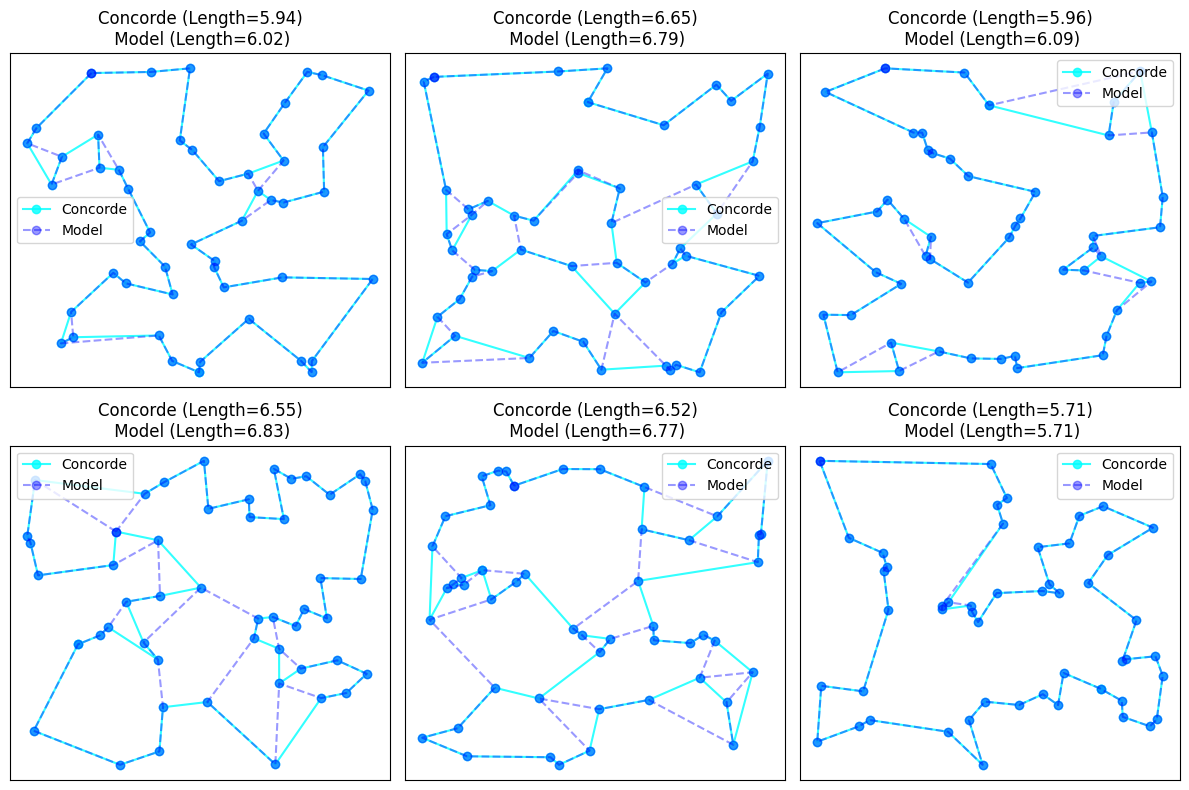

In [30]:
n_tours = len(concorde_tours)
n_cols = 3
n_rows = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

for idx in range(n_tours):
    points = np.array(x_test[idx].to('cpu'))
    concorde_tour = concorde_tours[idx]
    model_tour = model_tours[idx]

    # Prepare sequences for plotting
    sequence_points_concorde = np.vstack([points[concorde_tour], points[concorde_tour][0]])  # Close the loop
    sequence_points_model = np.vstack([points[model_tour], points[model_tour][0]])  # Close the loop

    # Plot both tours on the same subplot
    ax = axs[idx // n_cols, idx % n_cols]
    
    ax.plot(sequence_points_concorde[:, 0], sequence_points_concorde[:, 1], marker='o', 
            linestyle='-', color='cyan', alpha=0.8, label = 'Concorde')
    
    ax.plot(sequence_points_model[:, 0], sequence_points_model[:, 1], marker='o', 
            linestyle='--', color='blue', alpha=0.4, label = 'Model')
    
    ax.set_title(f'Concorde (Length={lengths_with_concorde[idx]:.2f})\n Model (Length={lengths_with_nn[idx]:.2f})')
    ax.legend()
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

plt.savefig('tsp50_paths_one_canvas.png')
plt.tight_layout()
plt.show()

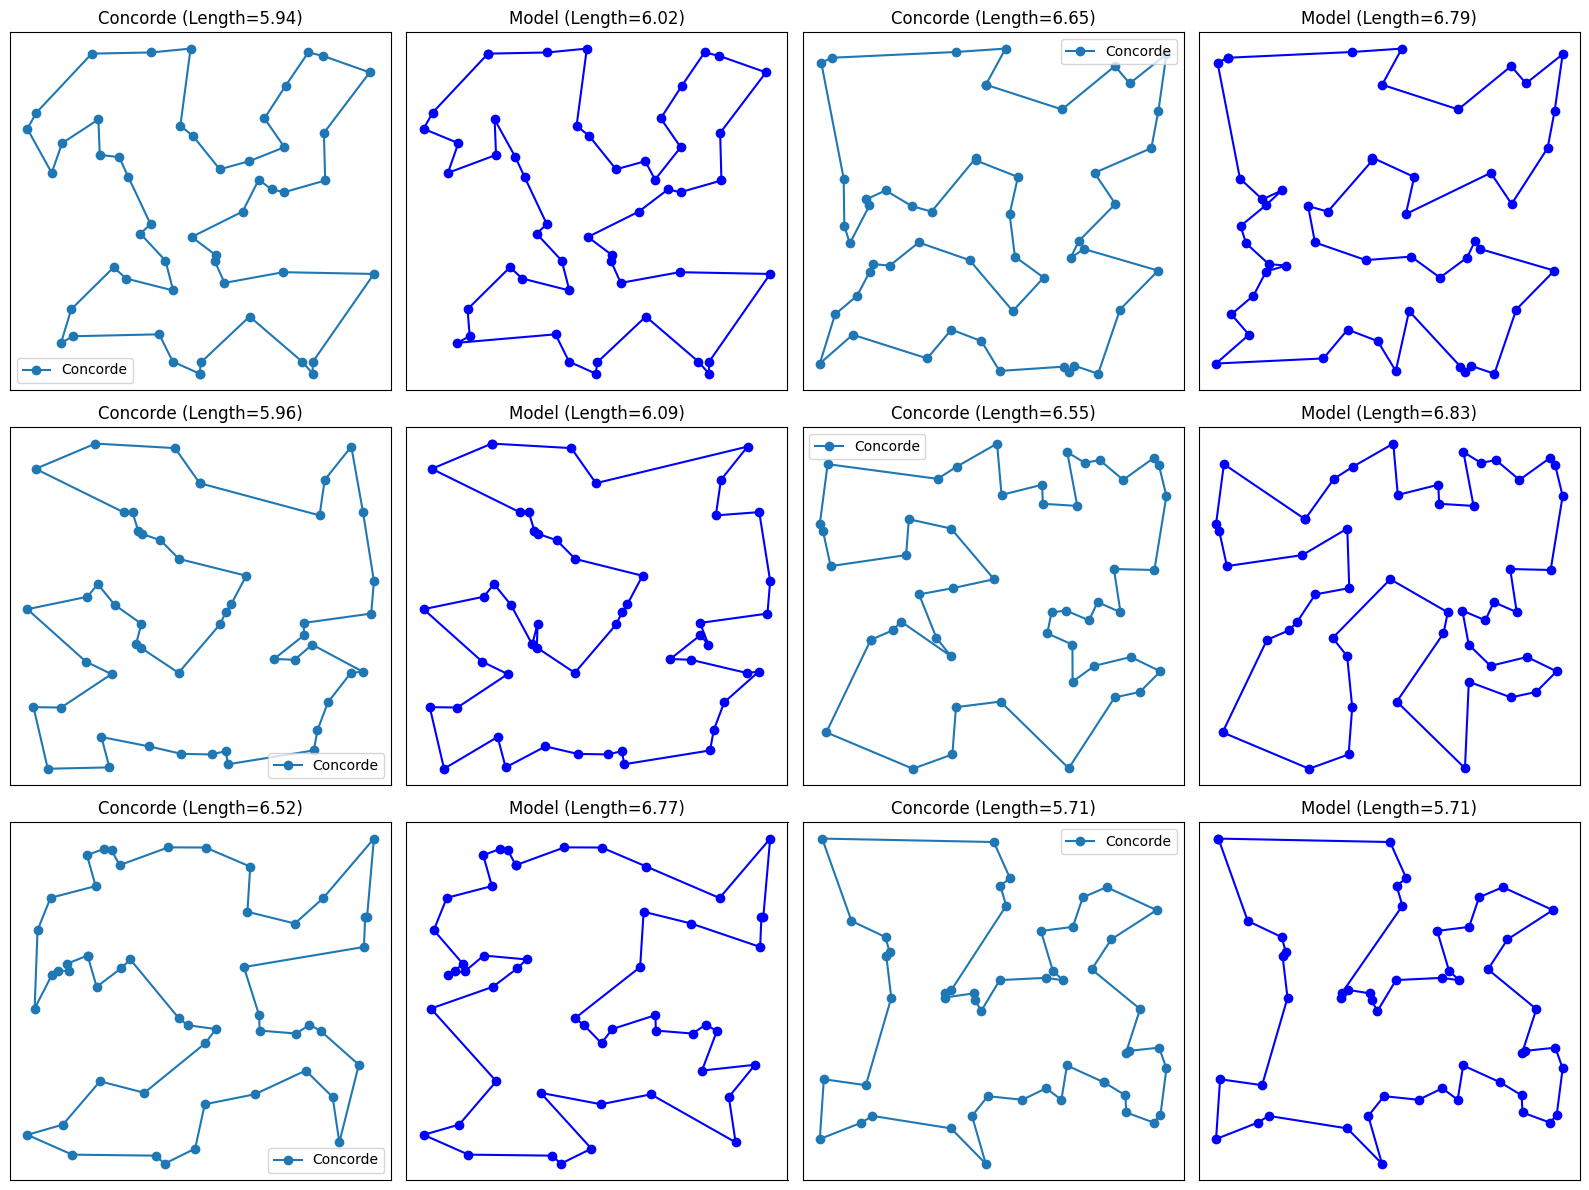

In [31]:
n_tours = len(concorde_tours)
n_cols = 2 * n_pairs
n_rows = 3

fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_pairs, 4 * n_rows))

for idx in range(n_tours):
    points = np.array(x_test[idx].to('cpu'))
    concorde_tour = concorde_tours[idx]
    model_tour = model_tours[idx]

    sequence_points_concorde = np.vstack([points[concorde_tour], points[concorde_tour][0]]) 
    sequence_points_model = np.vstack([points[model_tour], points[model_tour][0]]) 

    concorde_idx = idx * 2  # even columns for Concorde
    model_idx = idx * 2 + 1  # odd columns for model

    ax_concorde = axs[concorde_idx // n_cols, concorde_idx % n_cols]
    ax_concorde.plot(sequence_points_concorde[:, 0], sequence_points_concorde[:, 1], marker='o', label='Concorde')
    ax_concorde.set_title(f'Concorde (Length={lengths_with_concorde[idx]:.2f})')
    ax_concorde.legend()
    ax_concorde.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, 
                            labelbottom=False, labelleft=False)

    ax_model = axs[model_idx // n_cols, model_idx % n_cols]
    ax_model.plot(sequence_points_model[:, 0], sequence_points_model[:, 1], marker='o', color='blue', label='Model')
    ax_model.set_title(f'Model (Length={lengths_with_nn[idx]:.2f})')
    ax_model.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, 
                         labelbottom=False, labelleft=False)

plt.savefig('tsp50_paths_separate_canvas.png')
plt.tight_layout()
plt.show()